In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

2024-06-12 13:23:42.622617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 13:23:42.622666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 13:23:42.623518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 13:23:42.629450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 13:23:43.768912: W tensorflow/compiler/tf2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
from akita_utils.dna_utils import dna_1hot

from akita_utils.seq_gens import (
    symmertic_insertion_seqs_gen,
    reference_seqs_gen,
)
from akita_utils.tsv_utils import split_df_equally

from akita_utils.h5_utils import (
    initialize_stat_output_h5,
    initialize_maps_output_h5,
    initialize_maps_output_references,
    write_stat_metrics_to_h5,
    write_maps_to_h5,
)

from akita_utils.tsv_utils import (
    add_orientation,
    add_background,
    add_const_flank_and_diff_spacer,
)

In [5]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
# out_dir = "./OUT"
# stats = "SCD,INS-16,INS-64"
stats = "SCD"
# batch_size=8 
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"

In [6]:
# CTCT_table = "/home1/smaruj/akitaX1-analyses/experiments/virtual_insertion_experiment/input_data/CTCFs_jaspar_filtered_mm10_single_insertion_30flanks.tsv"
CTCT_table = "./picked_for_plotting.tsv"

In [7]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [8]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"

In [9]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"

In [10]:
params_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json'

In [11]:
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

In [12]:
model_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5'

In [13]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [14]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [15]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [16]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")

In [17]:
seq_coords_df = seq_coords_df.sort_values(by="SCD_B")

In [18]:
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]

In [19]:
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

In [20]:
# boundary exp
flank_length = 30
orient_list = ["<>"]
background_indices_list = [x for x in range(10)]
spacing_list=[60]

In [21]:
# adding orientation
B_seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
B_seq_coords_df = add_background(
    B_seq_coords_df, 
    background_indices_list
    )

In [22]:
B_seq_coords_df = add_const_flank_and_diff_spacer(
        B_seq_coords_df, 
        flank_length, 
        spacing_list
        )

In [23]:
# dot exp
flank_length = 30
orient_list = ["><"]
background_indices_list = [x for x in range(10)]
spacing_list=[199970]

In [24]:
# adding orientation
D_seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
D_seq_coords_df = add_background(
    D_seq_coords_df, 
    background_indices_list
    )

D_seq_coords_df = add_const_flank_and_diff_spacer(
        D_seq_coords_df, 
        flank_length, 
        spacing_list
        )

In [25]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

# num_insert_backgrounds = seq_coords_df["background_index"].max()
num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [ ]:
# initialize output
# stats_out = initialize_stat_output_h5(out_dir, model_file, stats, seq_coords_df)

In [26]:
#################################################################
# predictions for references
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 8s 1s/step


In [27]:
# boundary predictions
B_preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(B_seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [28]:
# dot predictions
D_preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(D_seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [29]:
from akita_utils.stats_utils import calculate_SCD
from akita_utils.analysis_utils import plot_map
from akita_utils.utils import ut_dense

In [30]:
num_experiments = len(B_seq_coords_df)
num_binding_sites = len(B_seq_coords_df["seq_index"].unique())
num_scenarios = 2  # B and D
num_backgrounds = 10
num_targets = 6
length_of_prediction_vector = 130305

summary_matrix = np.zeros((num_binding_sites, num_scenarios, num_backgrounds, num_targets, length_of_prediction_vector))

In [31]:
for exp_index in range(num_experiments):
    print(f"experiment {exp_index}")
    seq_index = B_seq_coords_df.iloc[exp_index].seq_index
    print("seq_index: ", seq_index)
    bg_index = B_seq_coords_df.iloc[exp_index].background_index
    
    B_prediction_matrix = B_preds_stream[exp_index]
    D_prediction_matrix = D_preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]
    
    B_difference_matrix = B_prediction_matrix - reference_prediction_matrix
    D_difference_matrix = D_prediction_matrix - reference_prediction_matrix
    
    # Accumulate differences for each target
    for target_index in range(num_targets):
        summary_matrix[seq_index, 0, bg_index, target_index, :] += B_difference_matrix[:, target_index]
        summary_matrix[seq_index, 1, bg_index, target_index, :] += D_difference_matrix[:, target_index]
    
    # ref_maps_t0 = ut_dense(reference_prediction_matrix)
    # B_alt_maps_t0 = ut_dense(B_prediction_matrix)
    # D_alt_maps_t0 = ut_dense(D_prediction_matrix)
    
    # print("ref")
    # plot_map(ref_maps_t0[:,:,0])
    # print("B-alt")
    # plot_map(B_alt_maps_t0[:,:,0])
    # print("B-alt-ref")
    # plot_map((B_alt_maps_t0 - ref_maps_t0).mean(axis=2))
    # print("D-alt")
    # plot_map(D_alt_maps_t0[:,:,0])
    # print("D-alt-ref")
    # plot_map((D_alt_maps_t0 - ref_maps_t0).mean(axis=2))

    # print("===================")
    
    # print("SCD, ref")
    # print(calculate_SCD(ref_maps_t0))
    # print("SCD, B-alt - ref")
    # print(calculate_SCD((B_alt_maps_t0 - ref_maps_t0).mean(axis=2)))
    # print("SCD, D-alt - ref")
    # print(calculate_SCD((D_alt_maps_t0 - ref_maps_t0).mean(axis=2)))   
        
    # print("SCD, ref")
    # print(calculate_SCD(ref_maps_t0))
    # print("SCD, alt")
    # print(calculate_SCD(alt_maps_t0))
    # print("SCD, alt with ref")
    # print(calculate_SCD(alt_maps_t0, ref_maps_t0))    

experiment 0
seq_index:  0
4/4 [==============================] - 21s 5s/step
experiment 1
seq_index:  1
experiment 2
seq_index:  2
experiment 3
seq_index:  3
experiment 4
seq_index:  4
experiment 5
seq_index:  5
experiment 6
seq_index:  0
experiment 7
seq_index:  1
experiment 8
seq_index:  2
experiment 9
seq_index:  3
experiment 10
seq_index:  4
experiment 11
seq_index:  5
experiment 12
seq_index:  0
experiment 13
seq_index:  1
experiment 14
seq_index:  2
experiment 15
seq_index:  3
experiment 16
seq_index:  4
experiment 17
seq_index:  5
experiment 18
seq_index:  0
experiment 19
seq_index:  1
experiment 20
seq_index:  2
experiment 21
seq_index:  3
experiment 22
seq_index:  4
experiment 23
seq_index:  5
experiment 24
seq_index:  0
experiment 25
seq_index:  1
experiment 26
seq_index:  2
experiment 27
seq_index:  3
experiment 28
seq_index:  4
experiment 29
seq_index:  5
experiment 30
seq_index:  0
experiment 31
seq_index:  1
experiment 32
seq_index:  2
4/4 [==============================

In [32]:
# averaging over backgrounds and targets
summary_matrix = summary_matrix.mean(axis=(2, 3))

In [33]:
from akita_utils.utils import ut_dense

In [ ]:
# chrom_start_end_list = [f"{row['chrom']}, {row['start']}-{row['end']}" for index, row in seq_coords_df.iterrows()]

In [34]:
chrom_start_end_list = ['chr11,\n 30,240,254-30,240,273',
 'chr10,\n 52,106,318-52,106,337',
 'chr17,\n 93,141,315-93,141,334',
 'chr17,\n 83,271,677-83,271,696',
 'chr9,\n 103,996,707-103,996,726',
 'chr13,\n 109,213,169-109,213,188']

In [ ]:
# labels = ["A", "B", "C", "D", "E", "F"]

In [ ]:
# picked_colors = ["#fef0d9", "#fdbb84", "#fc8d59", "#ef6548", "#d7301f", "#990000"]

plotting: sequence=0
plotting: sequence=1
plotting: sequence=2
plotting: sequence=3
plotting: sequence=4
plotting: sequence=5
plotting: sequence=0
plotting: sequence=1
plotting: sequence=2
plotting: sequence=3
plotting: sequence=4
plotting: sequence=5


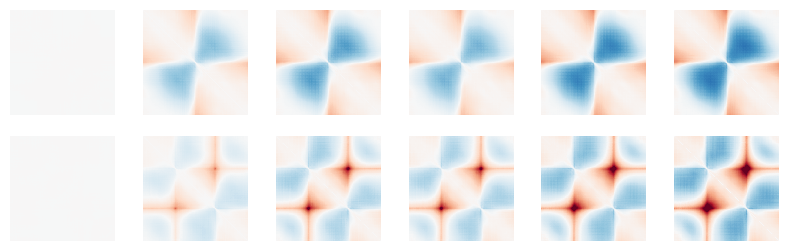

In [37]:
rows = ["boundary", "dot"]
num_sequences = 6
num_scenarios = 2

fig, axs = plt.subplots(num_scenarios, num_sequences, figsize=(10,3))

for scenario_idx in range(num_scenarios):
    for seq_idx in range(num_sequences):
        print(f"plotting: sequence={seq_idx}")
        
        plot_matrix = ut_dense(np.expand_dims(summary_matrix[seq_idx, scenario_idx, :], 1), diagonal_offset=2)
        plot_matrix = np.squeeze(plot_matrix, axis=2)
        
        vmin = -0.6
        vmax = 0.6
        
        sns.heatmap(
            plot_matrix,
            ax=axs[scenario_idx, seq_idx],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="RdBu_r",
            square=True,
            xticklabels=False,
            yticklabels=False,
        )
        
# for ax, col in zip(axs[0], labels):
#     color_index = labels.index(col)
#     ax.set_title(col, color=picked_colors[color_index], fontsize=20, fontweight='bold')

# for ax, row in zip(axs[:,0], rows):
#     ax.set_ylabel(row, rotation=0, fontsize=13, labelpad=35)

# a = np.array([[-0.6,0.6]])
# img = plt.imshow(a, cmap="RdBu_r")

# cb_ax = fig.add_axes([0.902, 0.125, 0.008, 0.335])
# cbar = fig.colorbar(img,orientation='vertical',cax=cb_ax)
# for t in cbar.ax.get_yticklabels():
#      t.set_fontsize(10)

# plt.savefig("name.png", format="png", dpi=400)
plt.savefig("./plots/dot_boundary_maps.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [38]:
print("done!")

done!


In [39]:
genome_open.close()